# DeepDeMix

This notebook requires python and tensorflow to be installed.

In [ ]:
%%capture
!pip install scaper
!pip install nussl
!pip install git+https://github.com/source-separation/tutorial

Make sure that ffmpeg is installed and up-to-date!

In [1]:
%%capture
from common import data, viz
import nussl
# Prepare MUSDB
data.prepare_musdb('~/.nussl/tutorial/')

In [2]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

Make sure that librosa is downgraded to 0.8.1!

If a later version is installed, run:

`$ pip install librosa==0.8.1`

In [ ]:
!pip install librosa==0.8.1

In [ ]:
import librosa
print(librosa.__version__)

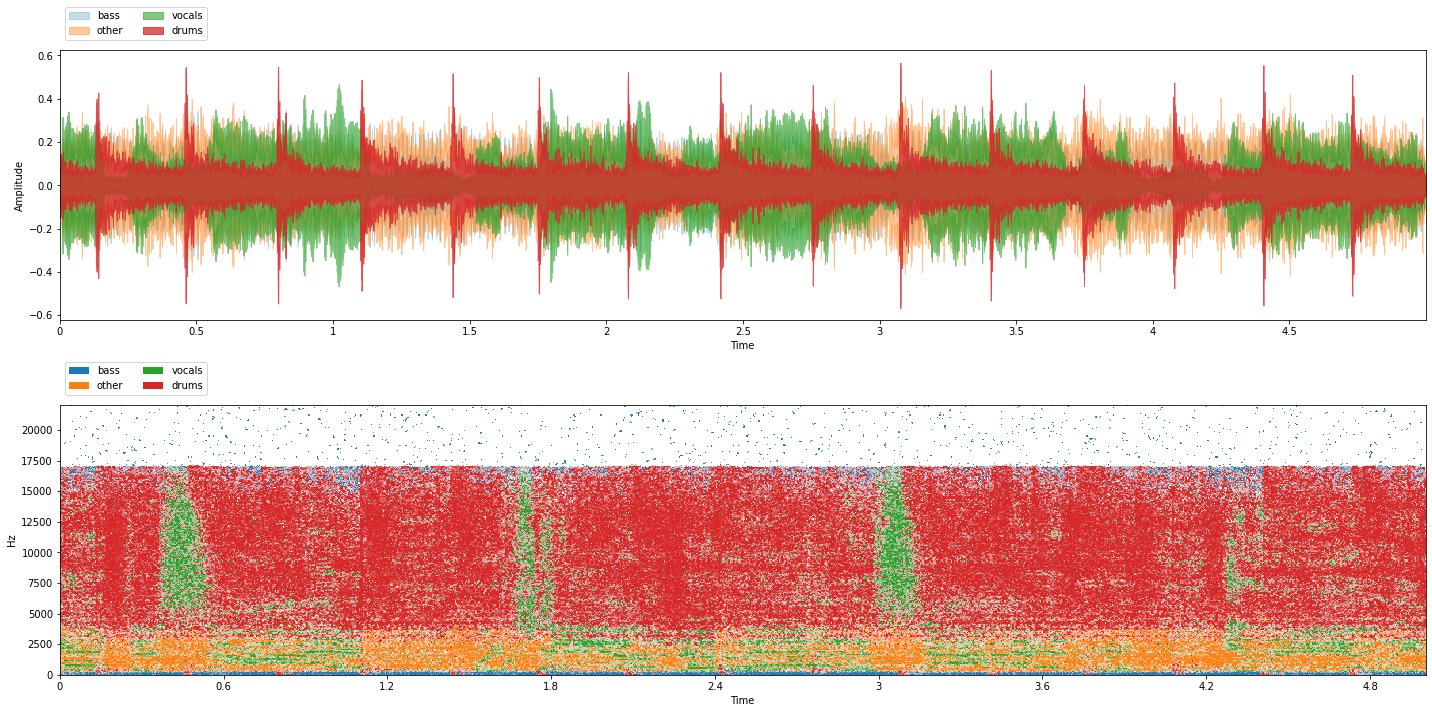


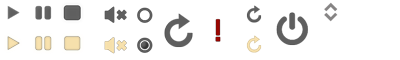
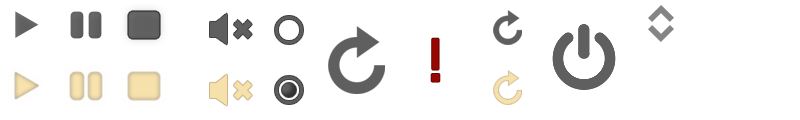
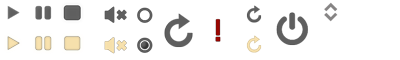

In [3]:
item = train_data[0]
viz.show_sources(item['sources'])

In [4]:
fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=500)

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=100)

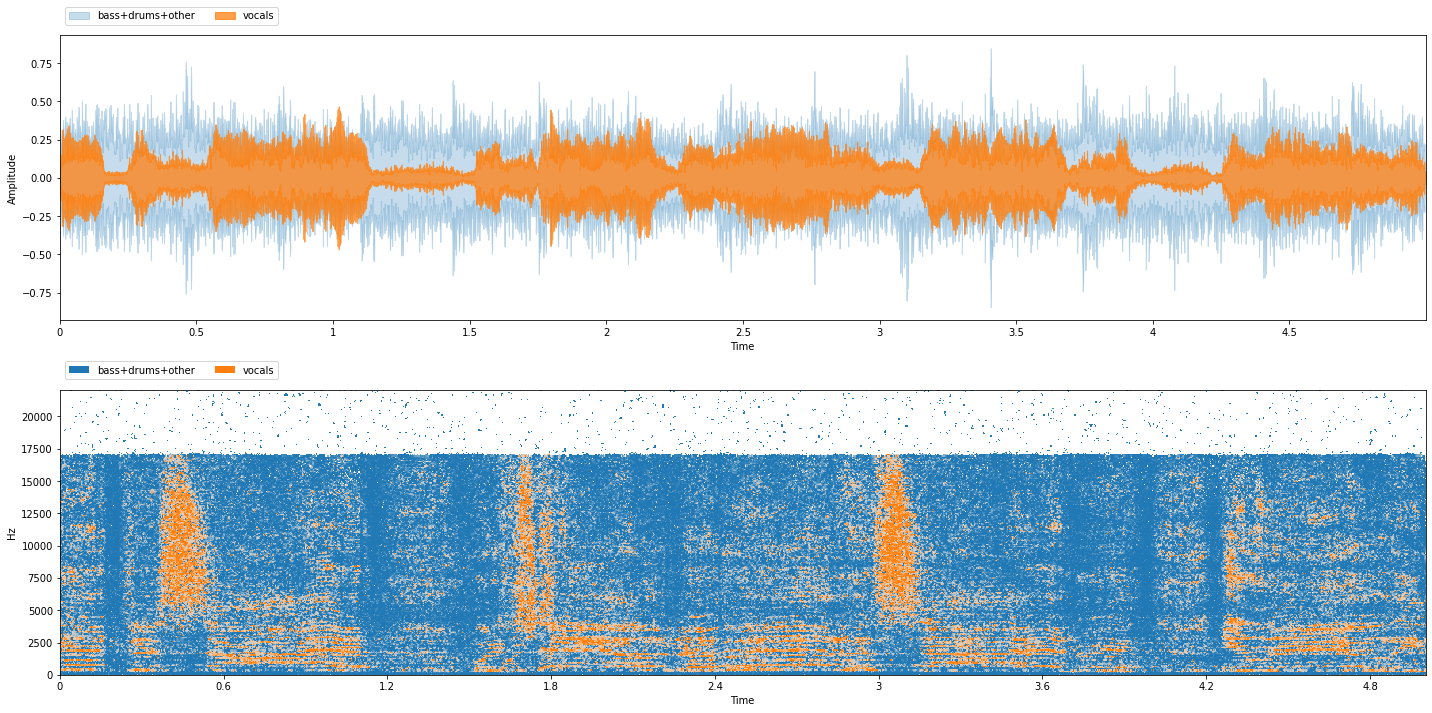


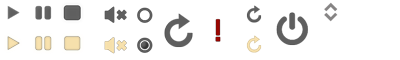
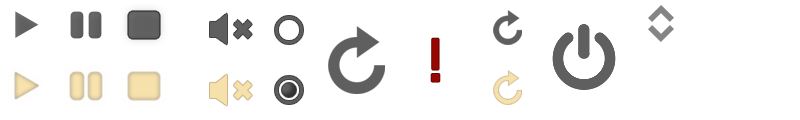
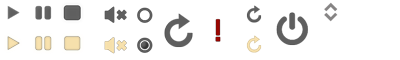

In [5]:
from nussl.datasets import transforms as nussl_tfm

item = train_data[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
item = sum_sources(item)
viz.show_sources(item['sources'])

In [6]:
msa = nussl_tfm.MagnitudeSpectrumApproximation()
item = msa(item)

print(item.keys())

dict_keys(['mix', 'sources', 'metadata', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


In [7]:
print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

(257, 1724, 1, 2) (257, 1724, 1) (257, 1724, 1, 2)


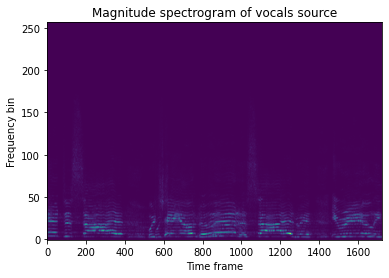

In [8]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 1][..., 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

In [9]:
index_sources = nussl_tfm.IndexSources('source_magnitudes', 1)
item = index_sources(item)

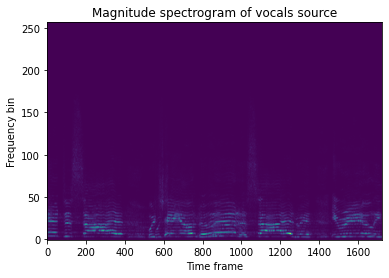

(257, 1724, 1, 1) (257, 1724, 1) (257, 1724, 1, 2)


In [10]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 0, 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

In [11]:
to_separation_model = nussl_tfm.ToSeparationModel()
item = to_separation_model(item)

In [12]:
print(item.keys())

dict_keys(['mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


In [13]:
for key in item:
    print(key, type(item[key]), item[key].shape)

mix_magnitude <class 'torch.Tensor'> torch.Size([1724, 257, 1])
ideal_binary_mask <class 'torch.Tensor'> torch.Size([1724, 257, 1, 2])
source_magnitudes <class 'torch.Tensor'> torch.Size([1724, 257, 1, 1])


In [14]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

item = train_data[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

Before transforms
mix <class 'nussl.core.audio_signal.AudioSignal'>
sources <class 'dict'>
metadata <class 'dict'>

After transforms
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


In [15]:
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

item = train_data[0]
print("Item from train data")
for key in item:
    print(key, type(item[key]))

fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=500)

test_tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=test_tfm, fg_path=fg_path, num_mixtures=100)

Item from train data
index <class 'int'>
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


In [16]:
"""
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from torch import nn
import torch

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
"""

"\nfrom nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding\nfrom torch import nn\nimport torch\n\nclass Model(nn.Module):\n    def __init__(self, num_features, num_audio_channels, hidden_size,\n                 num_layers, bidirectional, dropout, num_sources, \n                activation='sigmoid'):\n        super().__init__()\n        \n        self.amplitude_to_db = AmplitudeToDB()\n        self.input_normalization = BatchNorm(num_features)\n        self.recurrent_stack = RecurrentStack(\n            num_features * num_audio_channels, hidden_size, \n            num_layers, bool(bidirectional), dropout\n        )\n        hidden_size = hidden_size * (int(bidirectional) + 1)\n        self.embedding = Embedding(num_features, hidden_size, \n                                   num_sources, activation, \n                                   num_audio_channels)\n        \n    def forward(self, data):\n        mix_magnitude = data # save for masking\n        \n

In [17]:
"""
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from torch import nn
import torch

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
    
    # Added function
    @classmethod
    def build(cls, num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
        # Step 1. Register our model with nussl
        nussl.ml.register_module(cls)
        
        # Step 2a: Define the building blocks.
        modules = {
            'model': {
                'class': 'MaskInference',
                'args': {
                    'num_features': num_features,
                    'num_audio_channels': num_audio_channels,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'bidirectional': bidirectional,
                    'dropout': dropout,
                    'num_sources': num_sources,
                    'activation': activation
                }
            }
        }
        
        
        # Step 2b: Define the connections between input and output.
        # Here, the mix_magnitude key is the only input to the model.
        connections = [
            ['model', ['mix_magnitude']]
        ]
        
        # Step 2c. The model outputs a dictionary, which SeparationModel will
        # change the keys to model:mask, model:estimates. The lines below 
        # alias model:mask to just mask, and model:estimates to estimates.
        # This will be important later when we actually deploy our model.
        for key in ['mask', 'estimates']:
            modules[key] = {'class': 'Alias'}
            connections.append([key, f'model:{key}'])
        
        # Step 2d. There are two outputs from our SeparationModel: estimates and mask.
        # Then put it all together.
        output = ['estimates', 'mask',]
        config = {
            'name': cls.__name__,
            'modules': modules,
            'connections': connections,
            'output': output
        }
        # Step 3. Instantiate the model as a SeparationModel.
        return nussl.ml.SeparationModel(config)
"""
from models import MaskInference 

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

In [18]:
print(model.config)

{'name': 'MaskInference', 'modules': {'model': {'class': 'MaskInference', 'args': {'num_features': 257, 'num_audio_channels': 1, 'hidden_size': 50, 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3, 'num_sources': 1, 'activation': 'sigmoid'}, 'module_snapshot': "class MaskInference(nn.Module):\n    def __init__(self, num_features, num_audio_channels, hidden_size,\n                 num_layers, bidirectional, dropout, num_sources, \n                activation='sigmoid'):\n        super().__init__()\n        \n        self.amplitude_to_db = AmplitudeToDB()\n        self.input_normalization = BatchNorm(num_features)\n        self.recurrent_stack = RecurrentStack(\n            num_features * num_audio_channels, hidden_size, \n            num_layers, bool(bidirectional), dropout\n        )\n        hidden_size = hidden_size * (int(bidirectional) + 1)\n        self.embedding = Embedding(num_features, hidden_size, \n                                   num_sources, activation, \n           

In [19]:
print(model)

SeparationModel(
  (layers): ModuleDict(
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=100, out_features=257, bias=True)
      )
    )
    (mask): Alias()
    (estimates): Alias()
  )
)
Number of parameters: 210871


In [20]:
model.config['modules']['model']['args']

{'num_features': 257,
 'num_audio_channels': 1,
 'hidden_size': 50,
 'num_layers': 2,
 'bidirectional': True,
 'dropout': 0.3,
 'num_sources': 1,
 'activation': 'sigmoid'}

In [21]:
print(model.config['modules']['model']['module_snapshot'])

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
     

In [22]:
from common.models import MaskInference

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

In [23]:
print(model.config['modules']['model']['module_snapshot'])

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
     

In [24]:
import torch

item = train_data[0]
for key in item:
    if torch.is_tensor(item[key]):
        item[key] = item[key].float().unsqueeze(0)
output = model(item)

In [25]:
for key in output:
    print(key, type(output[key]), output[key].shape)

estimates <class 'torch.Tensor'> torch.Size([1, 1724, 257, 1, 1])
mask <class 'torch.Tensor'> torch.Size([1, 1724, 257, 1, 1])


In [26]:
model.verbose = True
output = model(item)

['mix_magnitude'] -> model 
	Took inputs: (1, 1724, 257, 1) 
	Produced 'model:mask': (1, 1724, 257, 1, 1), 'model:estimates': (1, 1724, 257, 1, 1) 
	Statistics:
		model:mask
			min: 0.2381
			max: 0.7595
			mean: 0.4999
			std: 0.0624
		model:estimates
			min: 0.0000
			max: 0.1205
			mean: 0.0016
			std: 0.0042
['model:mask'] -> mask 
	Took inputs: (1, 1724, 257, 1, 1) 
	Produced 'mask': (1, 1724, 257, 1, 1) 
	Statistics:
		mask
			min: 0.2381
			max: 0.7595
			mean: 0.4999
			std: 0.0624
['model:estimates'] -> estimates 
	Took inputs: (1, 1724, 257, 1, 1) 
	Produced 'estimates': (1, 1724, 257, 1, 1) 
	Statistics:
		estimates
			min: 0.0000
			max: 0.1205
			mean: 0.0016
			std: 0.0042


In [27]:
nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 1, True, 0.0, 1, 'sigmoid')
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

"""
def train_step(batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    return loss.item() # return the loss for bookkeeping.
"""

SeparationModel(
  (layers): ModuleDict(
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 50, batch_first=True, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=100, out_features=257, bias=True)
      )
    )
    (mask): Alias()
    (estimates): Alias()
  )
)
Number of parameters: 150071


"\ndef train_step(batch):\n    optimizer.zero_grad()\n    output = model(batch) # forward pass\n    loss = loss_fn(\n        output['estimates'],\n        batch['source_magnitudes']\n    )\n    \n    loss.backward() # backwards + gradient step\n    optimizer.step()\n    \n    return loss.item() # return the loss for bookkeeping.\n"

In [28]:
%%capture
# Comment out the line above to see the output
# of this cell in Colab or Jupyter Notebook
import tqdm
from train_utils import train_step_no_engine

item = train_data[0] # Because of the transforms, this produces tensors.
batch = {} # A batch of size 1, in this case. Usually we'd have more.
for key in item:
    if torch.is_tensor(item[key]):
        batch[key] = item[key].float().unsqueeze(0)
    
N_ITERATIONS = 100
loss_history = [] # For bookkeeping

pbar = tqdm.tqdm(range(N_ITERATIONS))
for _ in pbar:
    loss_val = train_step_no_engine(model, loss_fn, optimizer, batch)["loss"]
    loss_history.append(loss_val)
    pbar.set_description(f'Loss: {loss_val:.6f}')

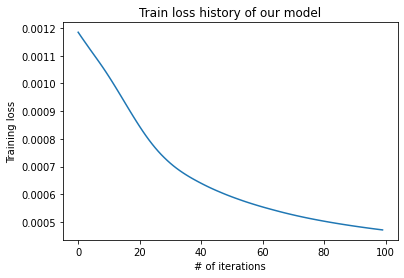

In [30]:
plt.plot(loss_history)
plt.xlabel('# of iterations')
plt.ylabel('Training loss')
plt.title('Train loss history of our model')
plt.show()

In [31]:
"""
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item()
    }
    
    return loss_vals # return the loss for bookkeeping.
"""

"\ndef train_step(engine, batch):\n    optimizer.zero_grad()\n    output = model(batch) # forward pass\n    loss = loss_fn(\n        output['estimates'],\n        batch['source_magnitudes']\n    )\n    \n    loss.backward() # backwards + gradient step\n    optimizer.step()\n    \n    loss_vals = {\n        'L1Loss': loss.item()\n    }\n    \n    return loss_vals # return the loss for bookkeeping.\n"

In [32]:
"""
def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {'L1Loss': loss.item()}
    return loss_vals # return the loss for bookkeeping.
"""

"\ndef val_step(engine, batch):\n    with torch.no_grad():\n        output = model(batch) # forward pass\n    loss = loss_fn(\n        output['estimates'],\n        batch['source_magnitudes']\n    )    \n    loss_vals = {'L1Loss': loss.item()}\n    return loss_vals # return the loss for bookkeeping.\n"

In [36]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from common.models import MaskInference
from common import utils, data
from pathlib import Path
from train_utils import train_step, val_step

utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "~/.nussl/tutorial/train"
val_folder = "~/.nussl/tutorial/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

nf = stft_params.window_length // 2 + 1
model = MaskInference.build(nf, 1, 50, 1, True, 0.0, 1, 'sigmoid')
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

"""
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals
"""

"""
def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals
"""
def train_step_engine(engine, batch):
    return train_step(model, loss_fn, optimizer, engine, batch)

def val_step_engine(engine, batch):
    return val_step(model, loss_fn, engine, batch)

# Create the engines
trainer, validator = nussl.ml.train.create_train_and_validation_engines(
    train_step_engine, val_step_engine, device=DEVICE
)

# We'll save the output relative to this notebook.
output_folder = Path('.').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
    optimizer, train_data, trainer, val_dataloader, validator)

trainer.run(
    train_dataloader, 
    epoch_length=10, 
    max_epochs=25
)

State:
	iteration: 250
	epoch: 25
	epoch_length: 10
	max_epochs: 25
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /home/ubuntu/DeepDeMix/checkpoints/best.model.pth
	output_folder: <class 'pathlib.PosixPath'>

In [37]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=DEVICE,
)

/home/ubuntu/.local/lib/python3.6/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/home/ubuntu/.local/lib/python3.6/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


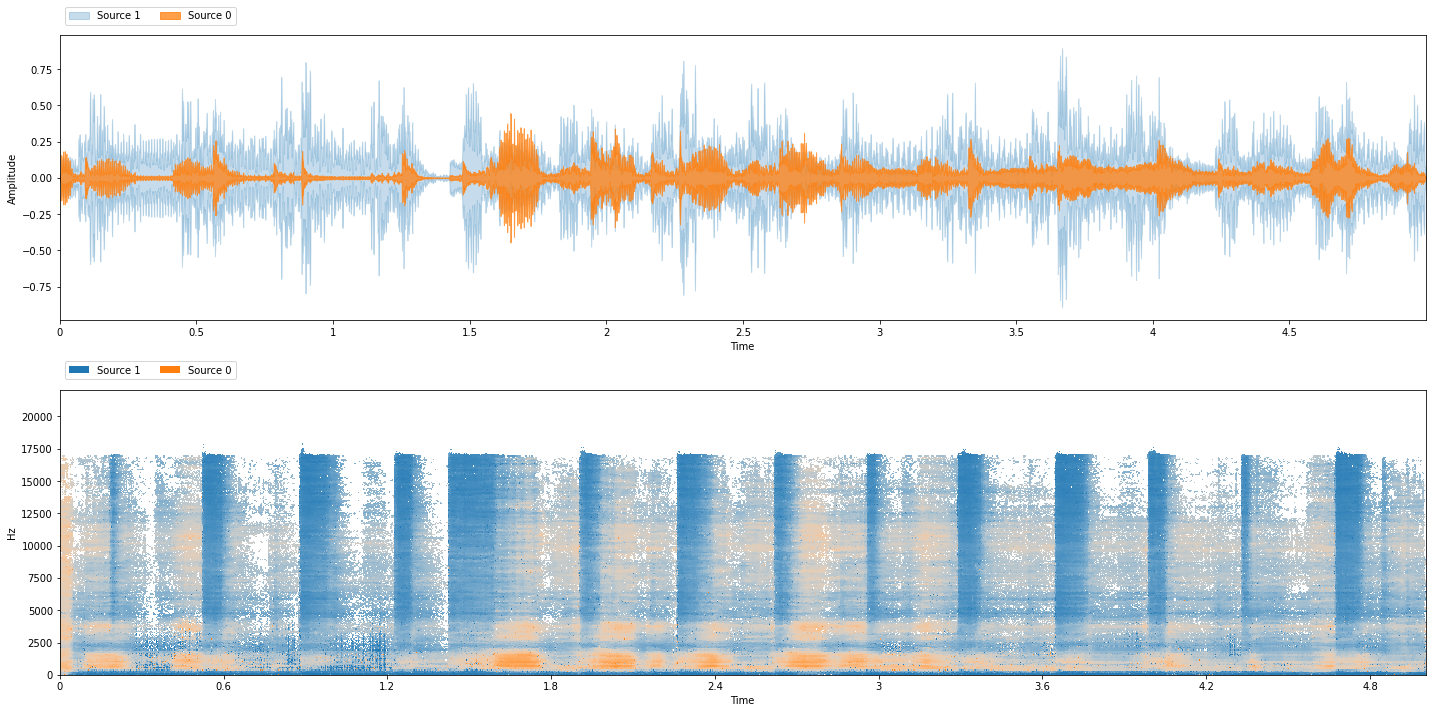


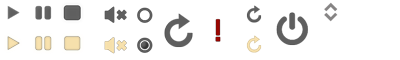
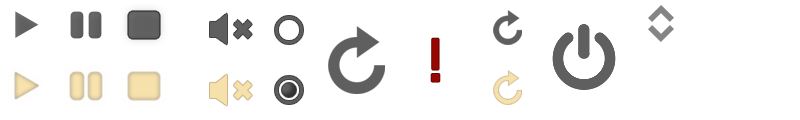
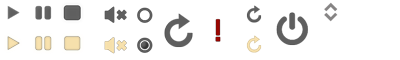

In [38]:
from common import viz

test_folder = "~/.nussl/tutorial/test/"
test_data = data.mixer(stft_params, transform=None, 
    fg_path=test_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
item = test_data[0]

separator.audio_signal = item['mix']
estimates = separator()
# Since our model only returns one source, let's tack on the
# residual (which should be accompaniment)
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

In [39]:
import json

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i in range(5):
    item = test_dataset[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_folder = Path(output_folder).absolute()
    output_folder.mkdir(exist_ok=True)
    output_file = output_folder / sources[0].file_name.replace('wav', 'json')
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)

In [40]:
import glob
import numpy as np

json_files = glob.glob(f"*.json")
df = nussl.evaluation.aggregate_score_files(
    json_files, aggregator=np.nanmedian)
nussl.evaluation.associate_metrics(separator.model, df, test_dataset)
report_card = nussl.evaluation.report_card(
    df, report_each_source=True)
print(report_card)

                                                                      
                        MEAN +/- STD OF METRICS                         
                                                                      
┌────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │ BASS+DRUMS+OTHER │      VOCALS      │
╞════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │        10        │        5         │        5         │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │   4.20 +/-  4.06 │   7.01 +/-  2.57 │   1.39 +/-  3.27 │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │   8.21 +/-  3.70 │   8.92 +/-  2.66 │   7.49 +/-  4.74 │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SAR     │   7.36 +/-  5.48 │  11.78 +/-  2.94 │   2.93 +/-  3.19 │
├────────────┼──────────────────┼──────────────────┼─────────────

In [41]:
separator.model.save('checkpoints/best.model.pth')

'checkpoints/best.model.pth'

In [ ]:
model_checkpoint = torch.load('checkpoints/best.model.pth')

In [ ]:
model_checkpoint['metadata'].keys()

In [ ]:
%%capture
separator.interact(share=True, source='microphone')